## The Complete List of Scenario Parameters

What follows is the minimum set of scenario-defining input parameters that your system must accept and
then use to build and run the ANN. Although these parameters can certainly be entered via an elaborate
graphical  user  interface  (GUI),  that  is  not  a  requirement  for  the  assignment.   It  is  fine  to  enter  them  as
arguments  to  a  single,  high-level  function  or  to  enter  them  via  a  scenario-defining  script.   If  entered  via
a GUI, any combination of menus, submenus, windows, sub-windows, etc.  is fine, but if entered by more
primitive means (i.e, function arguments or a script), then all data should be entered as the arguments to a
single function or as a single script.  In general, the specification of a scenario should be very straightforward
and thus facilitate a wide variety of user-specified runs during a short 10-15 minute demonstration period.
1.  Network Dimensions - the number of layers in the network along with the size of each layer.
2.  Hidden Activation Function - that function to be used for all hidden layers (i.e., all layers except the
input and output).
3.  Output  Activation  Function  -  this  is  often  different  from  the  hidden-layer  activation  function;  for
example, it is common to use
softmax
for classification problems, but only in the final layer.
4.  Cost Function - (a.k.a.  loss function) defines the quantity to be minimized, such as mean-squared error
or cross-entropy.
5.  Learning Rate - the same rate can be applied to each set of weights and biases throughout the network
and throughout the training phase.  More complex schemes, for example those that reduce the learning
rate throughout training, are possible but not required.
6.  Initial  Weight  Range  -  two  real  numbers,  an  upper  and  lower  bound,  to  be  used  when  randomly
initializing all weights (including those from bias nodes) in the network. Optionally, this parameter may
take a value such as the word
scaled
, indicating that the weight range will be calculated dynamically,
based on the total number of neurons in the upstream layer of each weight matrix.
7.  Data Source - specfied as either:
•
a data file along with any functions needed to read that particular file.
•
a function name (such as one of those in tflowtools.py) along with the parameters to that function,
such as the number and length of data vectors to be generated, the density range (i.e.  upper and
lower bound on the fraction of 1’s in the feature vectors), etc

8.  Case Fraction - Some data sources (such as MNIST) are very large, so it makes sense to only use a
fraction of the total set for the combination of training, validation and testing.  This should default to
1.0, but much lower values can come in handy for huge data files.
9.  Validation Fraction - the fraction of data cases to be used for validation testing.
10.  Test Fraction - the fraction of the data cases to be used for standard testing.
11.  Minibatch Size - the number of training cases in a minibatch
12.  Map Batch Size - the number of training cases to be used for a
map  test
(described below).  A value
of zero indicates that no map test will be performed.
13.  Steps - the total number of minibatches to be run through the system during training.
14.  Map Layers - the layers to be visualized during the map test.
15.  Map Dendrograms - list of the layers whose activation patterns (during the map test) will be used to
produce dendrograms, one per specified layer.  See below for more details on dendrograms.
16.  Display Weights - list of the weight arrays to be visualized at the end of the run.
17.  Display Biases - list of the bias vectors to be visualized at the end of the run.

## The code

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tflowtools as tft
import importlib
importlib.reload(tft)
np.random.seed(42)
%matplotlib inline

class Dataset_from_file():
    # Load a dataset from file
    def __init__(self, data, test_frac, val_frac):
        x = np.load(open("datsets/data+"_x.npy", "rb"))
        y = np.load(open("datasets/data+"_y.npy", "rb"))
        num_train_cols = x.shape[1]
        tot = np.concatenate((x, y), axis=1)
        np.random.shuffle(tot)
        x = tot[:,:num_train_cols]
        y = tot[:,num_train_cols:]
        n = len(x)
        self.train_x = x[0:int(n*(1-test_frac-val_frac))]
        self.train_y = y[0:int(n*(1-test_frac-val_frac))]
        self.test_x = x[int(n*(1-test_frac-val_frac)):int(n*(1-val_frac))]
        self.test_y = y[int(n*(1-test_frac-val_frac)):int(n*(1-val_frac))]
        self.val_x = x[int(n*(1-val_frac)):]
        self.val_y =y[int(n*(1-val_frac)):]     
        self.train_ind, self.test_ind = 0,0
        self.num_train = len(self.train_x)
        self.num_test = len(self.test_x)
        self.num_val = len(self.val_x)
    
    def get_next_train(self, n):
        # Get the nex training batch. If end will be reached next batch, reset and start over.
        res = (self.train_x[self.train_ind:self.train_ind+n], self.train_y[self.train_ind:self.train_ind+n])
        self.train_ind += n
        if self.train_ind > self.num_train-n:
            self.train_ind = 0
        return res
    
    def get_sample(self, n):
        # Get a random sample of the training data for mapping.
        inds = np.random.choice(range(self.num_train), size=n)
        return self.train_x[inds], self.train_y[inds]

class Dataset_from_func():
    # Load a dataset from a function. 
    def __init__(self, data, test_frac, val_frac):
        np.random.shuffle(data)
        self.train_x = np.array(list(zip(*data))[0])[0:int(len(data)*(1-test_frac-val_frac))]
        self.train_y = np.array(list(zip(*data))[1])[0:int(len(data)*(1-test_frac-val_frac))]
        self.test_x = np.array(list(zip(*data))[0])[int(len(data)*(1-test_frac-val_frac)):int(len(data)*(1-val_frac))]
        self.test_y = np.array(list(zip(*data))[1])[int(len(data)*(1-test_frac-val_frac)):int(len(data)*(1-val_frac))]
        self.val_x = np.array(list(zip(*data))[0])[int(len(data)*(1-val_frac)):]
        self.val_y = np.array(list(zip(*data))[1])[int(len(data)*(1-val_frac)):]        
        self.train_ind, self.test_ind = 0,0
        self.num_train = len(self.train_x)
        self.num_test = len(self.test_x)
        self.num_val = len(self.val_x)
        
    def get_next_train(self, n):
        # Get the nex training batch. If end will be reached next batch, reset and start over.
        res = (self.train_x[self.train_ind:self.train_ind+n], self.train_y[self.train_ind:self.train_ind+n])
        self.train_ind += n
        if self.train_ind > self.num_train-n:
            self.train_ind = 0
        return res
    
    def get_sample(self, n):
        # Get a random sample of the training data for mapping.
        inds = np.random.choice(range(self.num_train), size=n)
        return self.train_x[inds], self.train_y[inds]

class NN():
    def __init__(self, nn_dims, datasource, hidden_act_func="relu", output_act_func="softmax", loss_function="crossentropy", lr=0.001, init_w_range=(-1, 1), val_frac=0.1, test_frac=0.1, case_frac=1.0, vint=50, mini_batch_size=10, map_batch_size=10, steps=1000, map_layers=None, map_dendrograms=None, display_weights=None, display_biases=None):
        tf.reset_default_graph()
        # Get the dataset.
        self.dataset = Dataset_from_file(datasource, test_frac, val_frac) if type(datasource) == str else Dataset_from_func(datasource, test_frac, val_frac)
        self.n_input = len(self.dataset.train_x[0])
        self.n_classes = len(self.dataset.train_y[0])
        # Set activation function from chosen option in parameter list.
        self.hidden_act_options = {"relu": tf.nn.relu, "sigmoid": tf.sigmoid, "tanh": tf.tanh, "elu":tf.nn.elu, "softplus": tf.nn.softplus}
        self.hidden_act_func = self.hidden_act_options[hidden_act_func]
        self.output_act_options = {"softmax":tf.nn.softmax, "sigmoid":tf.sigmoid, "tanh":tf.tanh, "linear": lambda x: x}
        self.output_act_func = self.output_act_options[output_act_func]
        self.layers = [self.n_input]+ nn_dims
        self.learning_rate = lr
        self.init_w_range = init_w_range
        self.mbs = mini_batch_size
        self.steps = steps
        self.map_batch_size = map_batch_size
        self.display_weights = display_weights
        self.display_biases = display_biases
        self.map_dendrograms = map_dendrograms
        self.vint = vint
        self.X = tf.placeholder("float", [None, self.n_input],name="input_act")
        self.Y = tf.placeholder("float", [None, self.n_classes],name="output")
        self.variables = []
        # Build the network. 
        self.logits = self.build(self.X)
        self.map_layers = map_layers
        # Define variables that we want to grab.
        self.vars_to_grab = self.variables 
        # Set loss function
        if output_act_func in ["softmax", "sigmoid"] and loss_function == "crossentropy":
            loss_function = output_act_func+"_"+loss_function
        self.loss_function_options = {"mae": lambda x: tf.losses.absolute_difference(predictions = tf.argmax(self.output_act_func(x),1), labels=self.Y), 
                                      "mse": lambda x: tf.losses.mean_squared_error(predictions = tf.argmax(self.output_act_func(x),1), labels = self.Y),
                                      "softmax_crossentropy": lambda x: tf.losses.softmax_cross_entropy(logits=x, onehot_labels=self.Y), 
                                      "sigmoid_crossentropy": lambda x: tf.losses.sigmoid_cross_entropy(logits=x, multiclass_labels=self.Y), 
                                      "sparse_softmax_crossentropy":lambda x: tf.losses.sparse_softmax_cross_entropy(logits=x, labels=self.Y)}
        self.loss_function = self.loss_function_options[loss_function]
        # Apply the loss function to the logits. This returns the cost for an iteration.
        self.loss_op = self.loss_function(self.logits)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        # The train_op defines the operation to optimize the weights and biases for next iteration 
        # based on the loss at current iteration
        self.train_op = self.optimizer.minimize(self.loss_op)
        # Initializing the variables
        self.val_history = []
        self.tr_history = []
        self.sess = None
        
    def build(self, x):
        # Define the variables (tensors) for each layer to build the network.
        # Each layer consists of inputs, weights, biases, and forward its activations to the next layer.
        self.variables.append(self.X)
        for i, l in enumerate(self.layers[:-1]):
            w = tf.Variable(tf.random_uniform([l, self.layers[i+1]],self.init_w_range[0], self.init_w_range[1]), name="layer"+str(i)+"_wgt")
            b = tf.Variable(tf.random_uniform([self.layers[i+1]], self.init_w_range[0], self.init_w_range[1]),name="layer"+str(i)+"_bias")
            x = self.hidden_act_func(tf.add(tf.matmul(x, w), b), name="layer"+str(i)+"_act")
            self.variables.append(w)
            self.variables.append(b)
            self.variables.append(x)
        w = tf.Variable(tf.random_uniform([self.layers[-1],self.n_classes],self.init_w_range[0], self.init_w_range[1]), name="layer_out_wgt")
        b = tf.Variable(tf.random_uniform([self.n_classes], self.init_w_range[0], self.init_w_range[1]), name="layer_out_bias")
        x = tf.add(tf.matmul(x, w),b, name="layer_out_act")
        self.variables.append(w)
        self.variables.append(b)
        self.variables.append(x)
        self.variables.append(self.Y)
        # Note that we do not add the activation for the output layer, as this is done implicitly
        # in the softmax_crossentropy loss funciton.
        return x
    
    def predict(self, x, y):
        # Apply output activation function to logits
        pred = self.output_act_func(self.logits)  
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(self.Y, 1))
        # Calculate accuracy (Fraction of correct predictions after the max is chosen)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy.eval({self.X: x, self.Y: y}, session=self.sess))
    
    def run(self):
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        # Training cycle
        avg_cost = 0.
        for step in range(self.steps):
            batch_x, batch_y = self.dataset.get_next_train(self.mbs)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = self.sess.run([self.train_op, self.loss_op], feed_dict={self.X: batch_x,self.Y: batch_y})
            # Calculate errors for history.
            self.tr_history.append((step, c))
            # Display validation accuracy and training accuracy every vint step. 
            if step % self.vint == 0:
                val_error = self.sess.run([self.loss_op], feed_dict={self.X: self.dataset.val_x, self.Y: self.dataset.val_y})
                self.val_history.append((step, val_error[0]))
                print("Step:", '%04d' % (step), "Training error={:.9f}".format(c), "Validation error={:.4f}".format(val_error[0]))
                print("Training accuracy: ")
                self.predict(self.dataset.train_x, self.dataset.train_y)
                print("Validation accuracy: ")
                self.predict(self.dataset.val_x, self.dataset.val_y)
        print("Optimization Finished!")
        # do a final evaluation of training accuracy.
        print("Training accuracy: ")
        self.predict(self.dataset.train_x, self.dataset.train_y)
        # Evaluate test accuracy.
        print("Test accuracy:")
        self.predict(self.dataset.test_x, self.dataset.test_y)
        # Plot training history.
        self.plot_training_history()
        # Do mapping and plotting (if chosen)
        if self.map_batch_size > 0:
            self.map_res = self.do_mapping()
            self.do_plotting()
        self.sess.close()
        return
    
    def plot_training_history(self):
        tft.plot_training_history(self.tr_history, self.val_history)
    
    def do_mapping(self):
        # Get result from sending a sample through the network. 
        # No training occurs here.
        sample_x, sample_y = self.dataset.get_sample(self.map_batch_size)
        mappings = self.sess.run(self.variables,  feed_dict={self.X: sample_x, self.Y: sample_y})
        res = {v.name:m for v, m in zip(self.variables, mappings)}
        #preds = self.predict(sample_x, sample_y)
        return res
    
    def plot_map_layers(self):
        # Plot activation for selected layer(s).
        act_to_disp = [v.name for v in self.variables for m in self.map_layers if (m in v.name and "act" in v.name)]
        for act in act_to_disp:
            tft.hinton_plot(self.map_res[act], fig=plt.figure(),title=act)
    
    def plot_weights(self):
        # Plot weight matrix for selected layer(s).
        w_to_disp = [v.name for v in self.variables for m in self.display_weights if (m in v.name and "wgt" in v.name)]
        for w in w_to_disp:
            tft.display_matrix(self.map_res[w], fig=plt.figure(), title=w)
    
    def plot_biases(self):
        # Plot bias vector for selected layer(s)
        b_to_disp = [v.name for v in self.variables for m in self.display_biases if (m in v.name and "bias" in v.name)]
        for b in b_to_disp:
            tft.display_matrix(np.array([self.map_res[b]]), fig=plt.figure(), title=b)
            
    def plot_dendrograms(self):
        # Plot dendrograms for the selected layer(s).
        act_to_disp = [v.name for v in self.variables for m in self.map_dendrograms if (m in v.name and "act" in v.name)]
        for act in act_to_disp:
            inp = self.map_res["input_act:0"]
            labels = []
            for row in range(inp.shape[0]):
                labels.append("".join([str(int(x)) for x in inp[row,:]]))
            plt.figure()
            tft.dendrogram(self.map_res[act], labels)
    
    def do_plotting(self):
        # Gather all plotting in one function.
        if self.map_layers:
            self.plot_map_layers()
        if self.display_weights:
            self.plot_weights()
        if self.display_biases:
            self.plot_biases()
        if self.map_dendrograms:
            self.plot_dendrograms()

## Parity

In [2]:
parityparams = {"nn_dims":[100], 
                "datasource":tft.gen_all_parity_cases(10),
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.01,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":500,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":3000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [3]:
parity = NN(**parityparams)

Step: 0000 Training error=5.298065186 Validation error=2.7725
Training accuracy: 
0.499389
Validation accuracy: 
0.553398
Step: 0500 Training error=0.317002207 Validation error=0.5468
Training accuracy: 
0.912088
Validation accuracy: 
0.728155
Step: 1000 Training error=0.164191663 Validation error=0.4370
Training accuracy: 
0.958486
Validation accuracy: 
0.805825
Step: 1500 Training error=0.102562025 Validation error=0.3435
Training accuracy: 
0.990232
Validation accuracy: 
0.834951
Step: 2000 Training error=0.064878866 Validation error=0.3174
Training accuracy: 
0.996337
Validation accuracy: 
0.84466
Step: 2500 Training error=0.025159961 Validation error=0.3014
Training accuracy: 
0.998779
Validation accuracy: 
0.873786
Optimization Finished!
Training accuracy: 
0.997558
Test accuracy:
0.892157


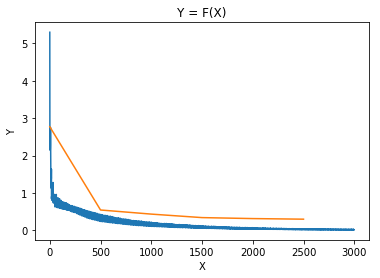

In [4]:
parity.run()

## Autoencoder

In [5]:
autoencoderparams = {"nn_dims":[8], 
                "datasource":tft.gen_all_one_hot_cases(8),
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.001,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":200,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":1000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [6]:
autoencoder = NN(**autoencoderparams)

Step: 0000 Training error=2.633730173 Validation error=2.0452
Training accuracy: 
0.166667
Validation accuracy: 
0.0
Step: 0200 Training error=1.610613465 Validation error=2.4227
Training accuracy: 
0.166667
Validation accuracy: 
0.0
Step: 0400 Training error=0.992842853 Validation error=2.7992
Training accuracy: 
0.833333
Validation accuracy: 
0.0
Step: 0600 Training error=0.543711066 Validation error=3.0988
Training accuracy: 
1.0
Validation accuracy: 
0.0
Step: 0800 Training error=0.314013600 Validation error=3.3075
Training accuracy: 
1.0
Validation accuracy: 
0.0
Optimization Finished!
Training accuracy: 
1.0
Test accuracy:
0.0


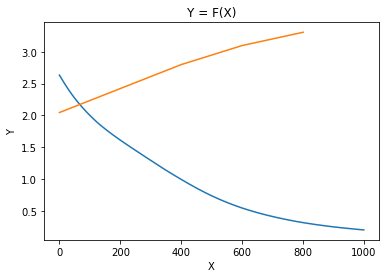

In [7]:
autoencoder.run()

## Segment Counter

In [8]:
segmentcounterparams = {"nn_dims":[100], 
                "datasource":tft.gen_segmented_vector_cases(15,1000,0,8),
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.01,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":200,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":1000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [9]:
segmentcounter = NN(**segmentcounterparams)

Step: 0000 Training error=10.242589951 Validation error=7.3794
Training accuracy: 
0.13
Validation accuracy: 
0.12
Step: 0200 Training error=0.708781600 Validation error=1.2491
Training accuracy: 
0.77
Validation accuracy: 
0.57
Step: 0400 Training error=0.374232680 Validation error=1.1781
Training accuracy: 
0.88875
Validation accuracy: 
0.6
Step: 0600 Training error=0.230112731 Validation error=1.1928
Training accuracy: 
0.935
Validation accuracy: 
0.62
Step: 0800 Training error=0.158063218 Validation error=1.2065
Training accuracy: 
0.97625
Validation accuracy: 
0.58
Optimization Finished!
Training accuracy: 
0.99625
Test accuracy:
0.7


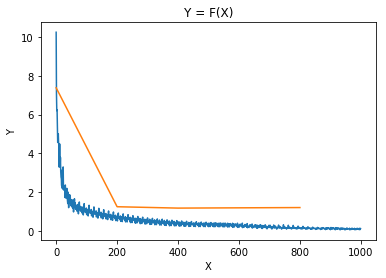

In [10]:
segmentcounter.run()

## MNIST

In [11]:
mnistparams = {"nn_dims":[50,50], 
                "datasource":"mnist",
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.01,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":1000,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":15000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [12]:
mnist = NN(**mnistparams)

Step: 0000 Training error=50.098789215 Validation error=40.9297
Training accuracy: 
0.121625
Validation accuracy: 
0.112
Step: 1000 Training error=0.088342488 Validation error=0.5358
Training accuracy: 
0.953625
Validation accuracy: 
0.895
Step: 2000 Training error=0.274008870 Validation error=0.6870
Training accuracy: 
0.96875
Validation accuracy: 
0.897
Step: 3000 Training error=0.005265498 Validation error=0.8073
Training accuracy: 
0.964
Validation accuracy: 
0.901
Step: 4000 Training error=0.152469516 Validation error=0.8449
Training accuracy: 
0.97725
Validation accuracy: 
0.902
Step: 5000 Training error=0.211692691 Validation error=0.6745
Training accuracy: 
0.988625
Validation accuracy: 
0.921
Step: 6000 Training error=0.011783835 Validation error=0.6165
Training accuracy: 
0.993125
Validation accuracy: 
0.936
Step: 7000 Training error=0.000059981 Validation error=0.8133
Training accuracy: 
0.98425
Validation accuracy: 
0.921
Step: 8000 Training error=0.035518266 Validation err

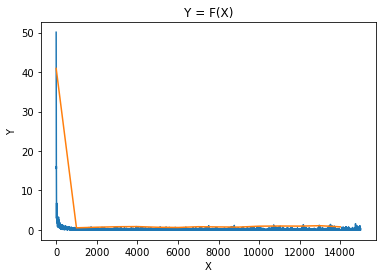

In [13]:
mnist.run()

## Winequality

In [14]:
wineparams = {"nn_dims":[100,100], 
                "datasource":"wine",
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.001,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":1000,
                "mini_batch_size":100,
                "map_batch_size":10, 
                "steps":5000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [15]:
wine = NN(**wineparams)

Step: 0000 Training error=41.532718658 Validation error=47.9434
Training accuracy: 
0.0906959
Validation accuracy: 
0.10625
Step: 1000 Training error=0.285817862 Validation error=2.5044
Training accuracy: 
0.864738
Validation accuracy: 
0.63125
Step: 2000 Training error=0.129269078 Validation error=2.4696
Training accuracy: 
0.949961
Validation accuracy: 
0.6625
Step: 3000 Training error=0.047312878 Validation error=2.5774
Training accuracy: 
0.969507
Validation accuracy: 
0.69375
Step: 4000 Training error=0.035561934 Validation error=2.7837
Training accuracy: 
0.971071
Validation accuracy: 
0.69375
Optimization Finished!
Training accuracy: 
0.973417
Test accuracy:
0.6375


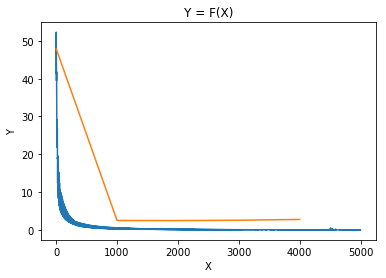

In [16]:
wine.run()

## Glass

In [1]:
glassparams = {"nn_dims":[100,100], 
                "datasource":"glass",
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.001,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":1000,
                "mini_batch_size":10,
                "map_batch_size":10, 
                "steps":3000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [18]:
glass = NN(**glassparams)

Step: 0000 Training error=30.770721436 Validation error=40.6845
Training accuracy: 
0.315789
Validation accuracy: 
0.272727
Step: 1000 Training error=0.002955628 Validation error=0.8876
Training accuracy: 
0.988304
Validation accuracy: 
0.727273
Step: 2000 Training error=0.013359043 Validation error=0.9551
Training accuracy: 
0.988304
Validation accuracy: 
0.772727
Optimization Finished!
Training accuracy: 
0.994152
Test accuracy:
0.761905


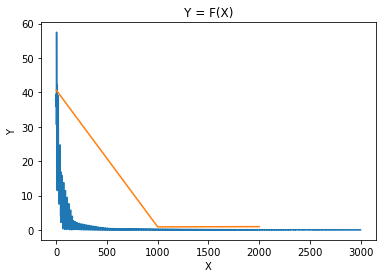

In [19]:
glass.run()

## Yeast

In [20]:
yeastparams = {"nn_dims":[50,50], 
                "datasource":"yeast",
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.002,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":3000,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":15000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [21]:
yeast = NN(**yeastparams)

Step: 0000 Training error=22.955068588 Validation error=21.8668
Training accuracy: 
0.0438079
Validation accuracy: 
0.0402685
Step: 3000 Training error=0.415464252 Validation error=1.7906
Training accuracy: 
0.812974
Validation accuracy: 
0.489933
Step: 6000 Training error=0.338129401 Validation error=2.6279
Training accuracy: 
0.914069
Validation accuracy: 
0.442953
Step: 9000 Training error=0.106500596 Validation error=3.7496
Training accuracy: 
0.950295
Validation accuracy: 
0.442953
Step: 12000 Training error=0.057904467 Validation error=5.1090
Training accuracy: 
0.973041
Validation accuracy: 
0.456376
Optimization Finished!
Training accuracy: 
0.908172
Test accuracy:
0.47973


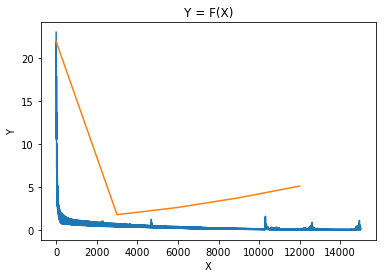

In [22]:
yeast.run()

## Pima Indians Diabetes (Hacker`s choice)

In [23]:
diabetesparams = {"nn_dims":[50,50], 
                "datasource":"glass",
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.002,
                "init_w_range":(-1, 1),
                "val_frac":0.1, 
                "test_frac":0.1,
                "case_frac":1.0, 
                "vint":200,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":2000, 
                "map_layers":None, 
                "map_dendrograms":None, 
                "display_weights":None, 
                "display_biases":None}

In [24]:
diabetes = NN(**diabetesparams)

Step: 0000 Training error=14.295496941 Validation error=9.7207
Training accuracy: 
0.216374
Validation accuracy: 
0.272727
Step: 0200 Training error=0.343299359 Validation error=1.4453
Training accuracy: 
0.912281
Validation accuracy: 
0.727273
Step: 0400 Training error=0.109503269 Validation error=1.5925
Training accuracy: 
0.929825
Validation accuracy: 
0.727273
Step: 0600 Training error=0.057675350 Validation error=1.6976
Training accuracy: 
0.94152
Validation accuracy: 
0.727273
Step: 0800 Training error=0.078539044 Validation error=1.8069
Training accuracy: 
0.953216
Validation accuracy: 
0.681818
Step: 1000 Training error=0.036664806 Validation error=1.9102
Training accuracy: 
0.959064
Validation accuracy: 
0.727273
Step: 1200 Training error=0.020713974 Validation error=2.0148
Training accuracy: 
0.959064
Validation accuracy: 
0.727273
Step: 1400 Training error=0.030651184 Validation error=2.1246
Training accuracy: 
0.953216
Validation accuracy: 
0.727273
Step: 1600 Training erro

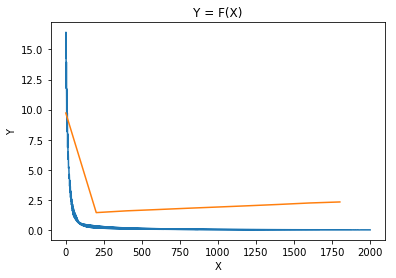

In [25]:
diabetes.run()

# Detailed explanation (Autoencoder)

## Weakly trained autoencoder (400 steps)

In [26]:
autoencoderparams = {"nn_dims":[3], 
                "datasource":tft.gen_all_one_hot_cases(8),
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.001,
                "init_w_range":(0, 1),
                "val_frac":0, 
                "test_frac":0,
                "case_frac":1.0, 
                "vint":200,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":400, 
                "map_layers":["input", "layer0", "out"], 
                "map_dendrograms":["layer0"], 
                "display_weights":["layer0", "out"], 
                "display_biases":["layer0", "out"]}

In [27]:
autoencoder = NN(**autoencoderparams)

Step: 0000 Training error=2.216889858 Validation error=0.0000
Training accuracy: 
0.125
Validation accuracy: 
nan
Step: 0200 Training error=1.843188763 Validation error=0.0000
Training accuracy: 
0.375
Validation accuracy: 
nan
Optimization Finished!
Training accuracy: 
0.625
Test accuracy:
nan


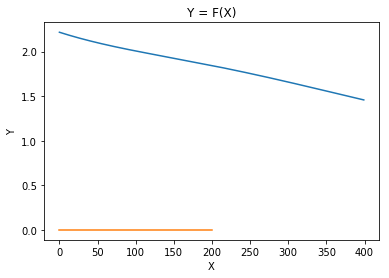

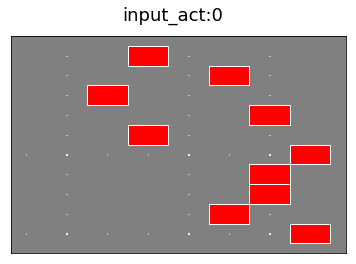

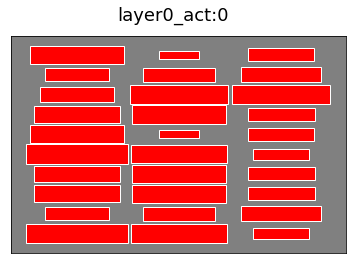

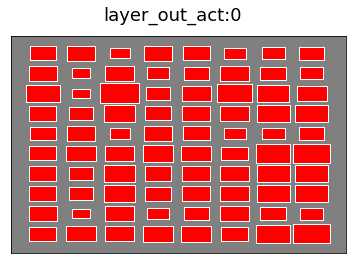

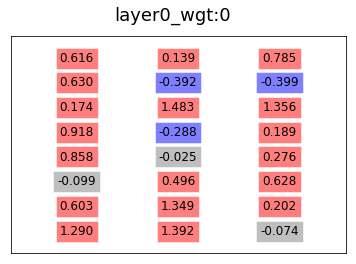

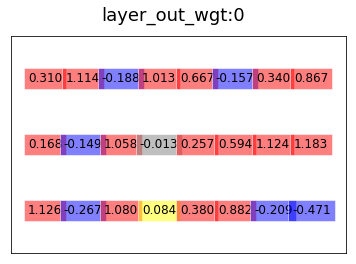

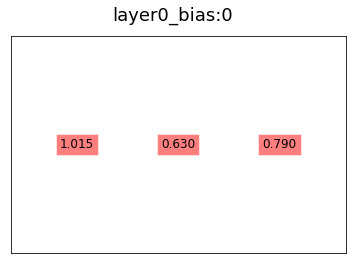

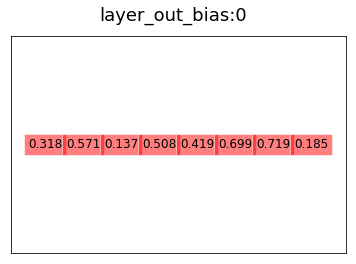

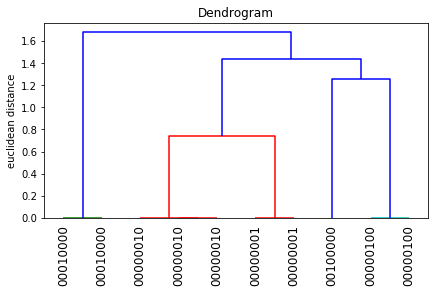

In [28]:
autoencoder.run()

We see that the autoencoder-network has not converged yet, and training accuracy is only at 50%. 

It is interesting to see the small differences in activation levels for the output nodes. For the dendrogram of the hidden layer there is also relatively small distances between the clusters. 

## Well trained autoencoder (1000 steps)

In [29]:
autoencoderparams = {"nn_dims":[3], 
                "datasource":tft.gen_all_one_hot_cases(8),
                "hidden_act_func":"relu", 
                "output_act_func":"softmax",
                "loss_function":"crossentropy",
                "lr":0.001,
                "init_w_range":(0, 1),
                "val_frac":0, 
                "test_frac":0,
                "case_frac":1.0, 
                "vint":200,
                "mini_batch_size":50,
                "map_batch_size":10, 
                "steps":2000, 
                "map_layers":["input", "layer0", "out"], 
                "map_dendrograms":["layer0"], 
                "display_weights":["layer0", "out"], 
                "display_biases":["layer0", "out"]}

In [30]:
autoencoder = NN(**autoencoderparams)

Step: 0000 Training error=2.205976725 Validation error=0.0000
Training accuracy: 
0.125
Validation accuracy: 
nan
Step: 0200 Training error=1.834597349 Validation error=0.0000
Training accuracy: 
0.375
Validation accuracy: 
nan
Step: 0400 Training error=1.434494495 Validation error=0.0000
Training accuracy: 
0.625
Validation accuracy: 
nan
Step: 0600 Training error=1.056437969 Validation error=0.0000
Training accuracy: 
0.75
Validation accuracy: 
nan
Step: 0800 Training error=0.783484340 Validation error=0.0000
Training accuracy: 
0.875
Validation accuracy: 
nan
Step: 1000 Training error=0.586643100 Validation error=0.0000
Training accuracy: 
1.0
Validation accuracy: 
nan
Step: 1200 Training error=0.441031903 Validation error=0.0000
Training accuracy: 
1.0
Validation accuracy: 
nan
Step: 1400 Training error=0.336015701 Validation error=0.0000
Training accuracy: 
1.0
Validation accuracy: 
nan
Step: 1600 Training error=0.258165777 Validation error=0.0000
Training accuracy: 
1.0
Validatio

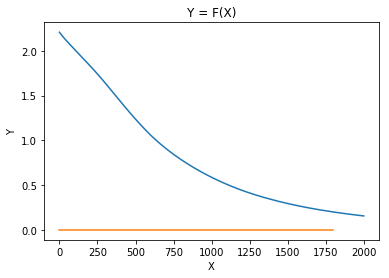

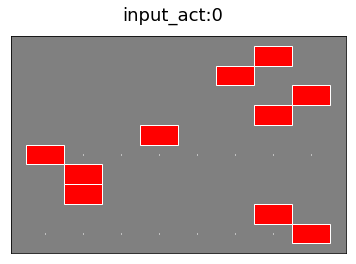

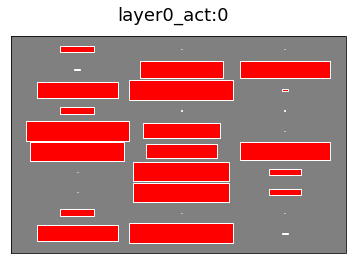

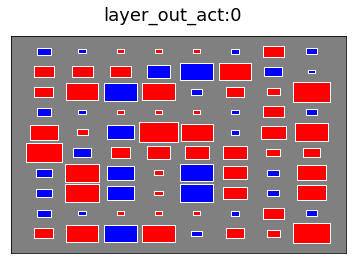

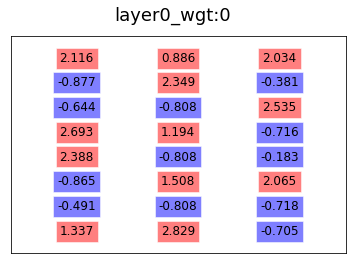

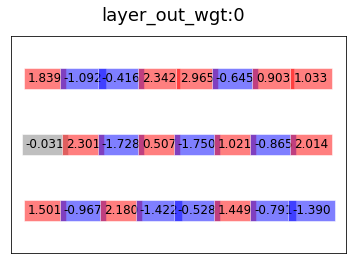

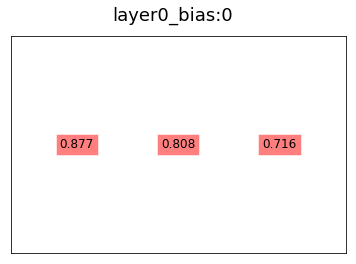

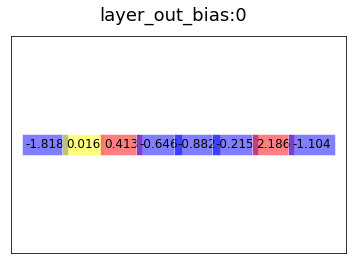

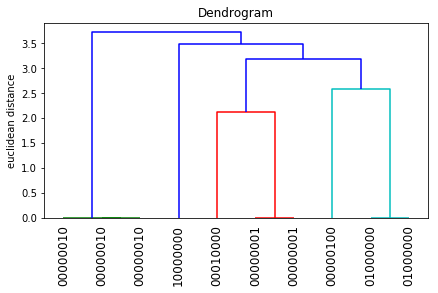

In [31]:
autoencoder.run()

We can see that the network has started to converge, and that output activations differs more between nodes, ie. the network give a stronger output activation to the correct output-nodes. The accuracy at this point is 100%, so the activated input-node is always the output node with the largest level of activation.

The autoencoder has learned the ability to compress the information from 8 bit to 3 bit, and has become a sort of "binary"-encoder, where each of the 8 input cases yields different actvation patterns in the 3 hidden nodes. (Though not corresponding to the real binary encodings).

For example [0,0,0,0,0,1,0,0] yields [1,1,1] in activation for the three hidden nodes, whereas [0,0,0,0,0,0,1,0] yields [0,0,0]. These activations can be explained if we look at the weights and bias in the corresponding positions.